# ML from scratch: Diffusion generative models, Day 1 (Theory)

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and John Vastola

## Teasers

* [Explaining DALL·E 2](https://youtu.be/qTgPSKKjfVg)
* [Craiyon / DALL·E 2 mini](https://www.craiyon.com/)
* [Disco Diffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb#scrollTo=DoTheRun)
* [How DALL·E 2 actually works](https://www.assemblyai.com/blog/how-dall-e-2-actually-works/)

<center>
<figure>
<img src="https://www.assemblyai.com/blog/content/images/size/w1000/2022/04/diffusion.png" alt="drawing" width="750">
<figcaption>Image from: https://www.assemblyai.com/blog/how-dall-e-2-actually-works/</figcaption>
</figure>
</center>

## Introduction

<center>
<figure>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/DiffusionGenerativeModels/images/dog_to_noise.jpg?raw=true" alt="drawing" width="600">
<figcaption>Image from: https://yang-song.github.io/blog/2021/score/</figcaption>
</figure>
</center>

**Welcome back to Machine Learning from Scratch!** For previous sessions, see the GitHub repository at: https://github.com/DrugowitschLab/ML-from-scratch-seminar

This session is on diffusion generative models, an approach to generating samples from distributions; it differs substantially from other approaches, like generative adversarial networks (GANs) and variational autoencoders (VAEs). Notably, it was one of the core ingredients of OpenAI's recent [DALL·E 2](https://openai.com/dall-e-2/) system for converting natural language descriptions to detailed images.

Diffusion generative models use the following idea. Samples from some distribution (e.g. of images) are gradually corrupted with more and more noise until they become unrecognizable static—this is the 'diffusion'. We then learn to *reverse* this mapping, so that we can turn unrecognizable static into a sample from our distribution of interest. Because it's easy to sample unrecognizable static, the mapping allows us to easily sample from our target distribution.

We will focus on the absolute basics of diffusion generative modeling, and restrict ourselves mostly to toy examples involving analytically tractable distributions.

**Helpful blog posts**:

https://yang-song.github.io/blog/2021/score/

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

**Relevant papers**:

[2021 Song et al.] [Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/forum?id=PxTIG12RRHS)

[2019 Song and Ermon] [Generative Modeling by Estimating Gradients of the Data Distribution](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html)

[2015 Sohl-Dickstein et al.] [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](http://proceedings.mlr.press/v37/sohl-dickstein15.html)

---------------------------------------------------

## 0. Motivation

"*Creating noise from data is easy; creating data from noise is generative modeling.*" - [Song et al.](https://openreview.net/forum?id=PxTIG12RRHS)

Generative modeling is an area of statistics and machine learning that involves approximating the probability distribution from which a given set of data is sampled. By learning such a distribution (e.g. of pictures of faces), we can sample *new* data from it—e.g. a new image of a face.

In neuroscience, people care about generative models for at least two different reasons. They can be used to [generate novel stimuli](https://www.cell.com/cell/fulltext/S0092-8674(19)30391-5) to better understand neuronal tuning curves (particularly in vision); also, it is [widely](https://www.frontiersin.org/articles/10.3389/fncom.2018.00090/full) [speculated](https://www.frontiersin.org/articles/10.3389/frai.2019.00018/full) that some of the brain's models of the world may involve generative components. Such generative components may [help us make sense of](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003134) sensory-deprivation-related hallucinations, like those experienced by patients with [Charles Bonnet syndrome](https://en.wikipedia.org/wiki/Visual_release_hallucinations). See Oliver Sacks' [*Hallucinations*](https://en.wikipedia.org/wiki/Hallucinations_(book)) for many interesting related neurological anecdotes.





There are different approaches to generative modeling, including using [generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) (GANs) and [variational autoencoders](https://en.wikipedia.org/wiki/Variational_autoencoder) (VAEs). One somewhat newer approach involves adding a large amount of noise to samples, and then learning to *undo* the noise. In this way, we can learn to convert pure noise into samples from some distribution we're interested in. Because it's easy to generate all sorts of samples of pure noise, and each gets transformed by our noise-undoing-mapping to samples from our target distribution, we have a generative model.

<center>
<figure>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/DiffusionGenerativeModels/images/forward_diffusion_movie.gif?raw=true">
<figcaption>Turning a distribution sample into unrecognizable static by adding lots of noise.<br>
Image from: https://yang-song.github.io/blog/2021/score/</figcaption>
</figure>
</center>

<center>
<figure>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/DiffusionGenerativeModels/images/reverse_diffusion_movie.gif?raw=true">
<figcaption>Turning noise into a distribution sample.<br>
Image from: https://yang-song.github.io/blog/2021/score/</figcaption>
</figure>
</center>

There are various appealing features to this approach to generative modeling. One notable one is that we do not have to directly learn a probability distribution, but can instead learn a related function sometimes called the **score**. This is the gradient of the log of the probability density function.

$$\mathbf{s}(\mathbf{x}) := \nabla_{\mathbf{x}} \log p(\mathbf{x})$$

This allows us to avoid having to learn a normalization constant for our probability density, which is an often troublesome task.

What can we do with a diffusion-based generative model? We can do things like:

1.   Class-conditional generation (given a class label, generate a new example)
2.   Inpainting (filling in the missing parts of a partly corrupted image)
3.   Colorization (adding plausible color to a grayscale image)

...and more! See [Song et al. 2021](https://openreview.net/forum?id=PxTIG12RRHS) for more discussion of these applications.



<center>
<figure>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/DiffusionGenerativeModels/images/bedroom_restoration_example.png?raw=true" width=700>
<figcaption>Image inpainting example.<br>
Adapted from Song et al. 2021.</figcaption>
</figure>
</center>

-----------------------------------------------------

## 1. Forward diffusion, and a little bit of stochastic processes review

How do we add noise to distribution samples 'properly'? Although views on this have varied, recent work has [unified](https://openreview.net/forum?id=PxTIG12RRHS) different approaches. By and large, various ideas about how to do this amount to subjecting a given distribution sample to a kind of *diffusion process*. More generally, we can imagine applying some kind of stochastic process (defined by a stochastic differential equation, or SDE) to a distribution sample.

### Basics of diffusion

Let's view the basics of diffusion. A one-dimensional diffusion process (on the real line) can be defined by the SDE

$$\dot{x} = \sigma \ \eta(t)$$

where $\sigma > 0$ is a constant, and $\eta(t)$ denotes a Gaussian white noise term.

*What does this even mean?* We can make the above expression concrete by defining it to be the small $\Delta t$ limit of the discrete process for which

$$x(t + \Delta t) = x(t) + \sigma \sqrt{\Delta t} \ r$$

where $r \sim \mathcal{N}(0, 1)$ is a sample from a standard normal distribution. This is an example of an [**Euler-Maruyama time step**](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method).

The above description of diffusion is useful for doing simulations. Given a number $x$, we can use the above update rule to subject it to one time step of diffusion. But a complementary view describes how the probability density $p(x, t)$, the probability of the system being at position $x$ at time $t$, changes over time.

In particular, $p(x, t)$ changes according to the well-known diffusion equation:

$$\frac{\partial p(x, t)}{\partial t} = \frac{\sigma^2}{2} \frac{\partial^2 p(x, t)}{\partial x^2} \ .$$

You may be used to seeing this equation with a diffusion constant $D$ instead of a parameter $\sigma$. The conversion between them is that $D := \sigma^2/2$.

The solution to the diffusion equation, given a delta function initial condition $p(x, 0) = \delta(x - x_0)$ (that is, given that we are initially certain that the system is at location $x_0$) is the well-known [heat kernel](https://en.wikipedia.org/wiki/Heat_kernel):

$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 t}  \right\} \ . $$

Given an arbitrary initial condition $p(x, 0) = p_0(x)$, the general solution of the diffusion equation is then

$$p(x, t) = \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0 \ .$$

###Basics of stochastic differential equations (SDEs)

Diffusion is just one particularly simple example of a stochastic process governed by an SDE. The most general one-dimensional SDE looks like

$$\dot{x} = f(x, t) + g(x, t) \ \eta(t)$$

where $f(x, t)$ and $g(x, t)$ are functions, and $\eta(t)$ is again a Gaussian white noise term. The function $f(x, t)$ is the *drift* term, and describes how the average value of $x(t)$ evolves with time. The term involving $g(x, t)$ is the *noise* or *diffusion* term, and describes stochastic fluctuations in the value of $x(t)$.

*What does this even mean?* Unlike in the case of diffusion, for which $g(x, t)$ is a constant, there are additional mathematical subtleties associated with making the above expression well-defined. For our purposes, we can choose the convention known as the [*Ito interpretation*](https://en.wikipedia.org/wiki/It%C3%B4_calculus), which defines the above expression to be the small $\Delta t$ limit of the discrete process

$$x(t + \Delta t) = x(t) + f(x(t), t) \Delta t + g(x, t) \sqrt{\Delta t} \ r$$

where $r \sim \mathcal{N}(0, 1)$ is a sample from a standard normal distribution. This is a more general Euler-Maruyama time step (although it is still not the *most* general form of it, given that we are only working in one dimension for now).

The analogue to the diffusion equation is the [**Fokker-Planck equation**](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation) (FPE), which describes how $p(x, t)$ evolves in time for a system described by an SDE. For the one-dimensional Ito-interpreted system written above, it is given by

$$\frac{\partial p(x, t)}{\partial t} = - \frac{\partial}{\partial x} \left[ \  f(x, t) p(x, t) \ \right] + \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, t)^2}{2} p(x, t) \ \right] \ .$$

Most FPEs are difficult or impossible to solve analytically, so we may not be able to get exact solutions for $p(x, t)$. Notable cases where we *can* solve for $p(x, t)$ exactly include diffusion and [Ornstein-Uhlenbeck-like processes](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) (OU processes). OU processes are mean-reverting stochastic processes; a one-dimensional example is the SDE

$$\dot{x} = \frac{1}{\tau} \left[ \mu - x \right] + \sigma \sqrt{\frac{2}{\tau}} \ \eta(t) \ .$$

Its solution (for an initial condition $p(x, 0) = \delta(x - x_0)$) is

$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi s(t)^2}} \exp\left\{ - \frac{[ x - \mu(t) ]^2}{2 s(t)^2}  \right\} $$

where

$$
\begin{split}
\mu(t) &:= x_0 e^{- t/\tau} + \mu \left( 1 - e^{- t/\tau} \right) \\
s(t)^2 &:= \sigma^2 \left( 1 - e^{- 2 t/\tau} \right) \ .
\end{split}
$$

In the long-time limit ($t \to \infty$), we have
$$p(x, t | x_0, 0) \xrightarrow{t \to \infty} p_{ss}(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left\{ - \frac{(x - \mu)^2}{2 \sigma^2}  \right\} \ ,$$
i.e. the steady-state solution $p_{ss}(x)$ is a Gaussian with mean $\mu$ and variance $\sigma^2$.  

The general solution to this OU process (given an initial distribution $p(x, 0) = p_0(x)$) is
$$p(x, t) = \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0 \ .$$

One thing that makes OU processes somewhat different from a strict diffusion process is that their long-time behavior loses all memory of their initial condition. That is, as $t$ increases, $p(x, t)$ depends less and less on $p_0(x)$.

###Basic example code

Let's see what it might look like to simulate 1D diffusion, a particularly simple stochastic process. You can also play with the code yourself to simulate other SDEs, like an OU process.

Import libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

Below are some utility functions. The first few functions are used to forward simulate 1D diffusion (although `forward_SDE_simulation` can be used to simulate more general SDEs). The last function outputs the analytic transition probability for 1D diffusion, which we can use to validate our simulations.

In [2]:
# Simulate SDE with drift function f and noise amplitude g for arbitrary number of steps
def forward_SDE_simulation(x0, nsteps, dt, f, g, params):

  # Initialize time and a stochastic trajectory
  t = 0
  x_traj = np.zeros((nsteps + 1, *x0.shape))
  x_traj[0] = np.copy(x0)


  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    random_normal = np.random.randn(*x0.shape)        # standard normal random number

    x_traj[i+1] = x_traj[i] + f(x_traj[i], t, params)*dt + g(x_traj[i], t, params)*np.sqrt(dt)*random_normal
    t = t + dt

  return x_traj


# Drift function for diffusion (returns zeros)
def f_diff_simple(x, t, params):
  return np.zeros((*x.shape,))


# Noise amplitude for diffusion (constant)
def g_diff_simple(x, t, params):
  sigma = params['sigma']
  return sigma*np.ones((*x.shape,))


# Exact transition probability for 1D diffusion
def transition_probability_diffusion_exact(x, t, params):
  x0, sigma= params['x0'], params['sigma']

  pdf = norm.pdf(x, loc=x0, scale=np.sqrt((sigma**2)*t))  # pdf of normal distribution with mean x0 and variance (sigma^2)*t
  return pdf

Simulation parameters.

In [3]:
sigma = 1         # noise amplitude for 1D diffusion

num_samples = 1000
x0 = np.zeros(num_samples)    # initial condition for diffusion


nsteps = 2000      # number of simulation steps
dt = 0.001          # size of small time steps
T = nsteps*dt
t = np.linspace(0, T, nsteps + 1)


params = {'sigma': sigma, 'x0':x0, 'T':T}

Forward simulate the model.

In [4]:
x_traj = forward_SDE_simulation(x0, nsteps, dt, f_diff_simple, g_diff_simple, params)

Plot results.

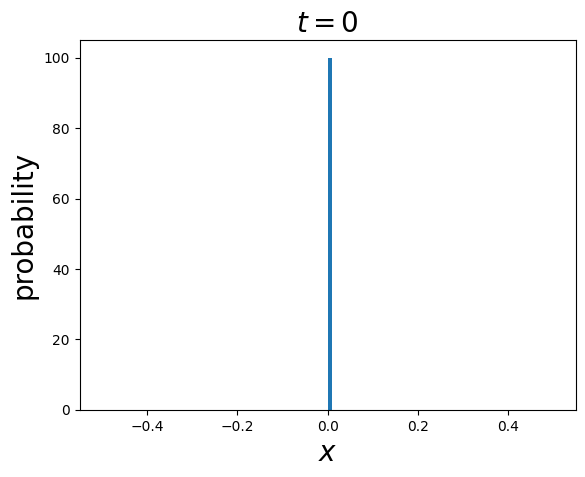

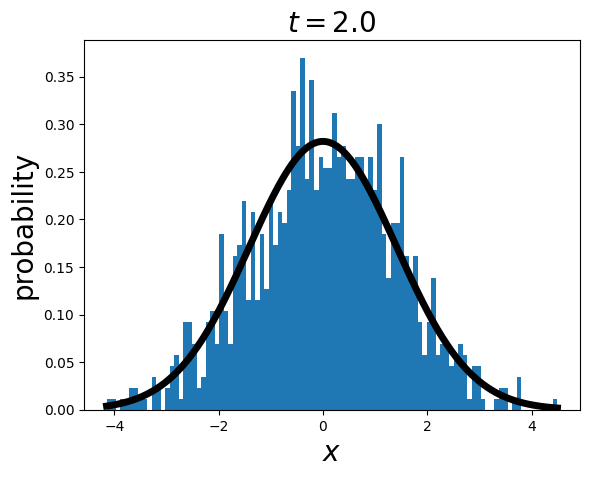

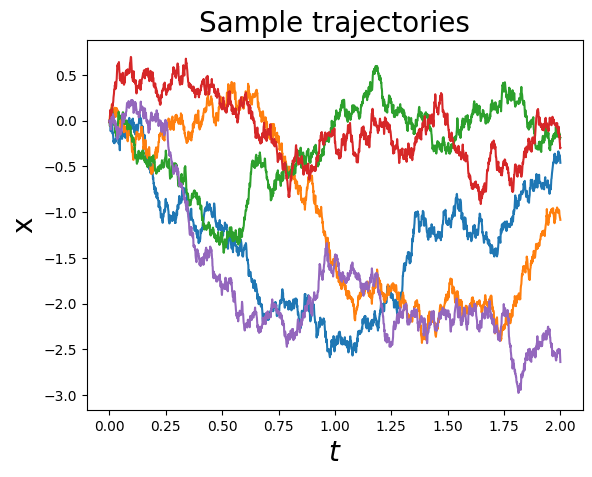

In [5]:
# Plot initial distribution (distribution before diffusion)
plt.hist(x_traj[0], density=True, bins=100)
plt.title("$t = 0$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Compute exact transition probability
x_f_min, x_f_max = np.amin(x_traj[-1]), np.amax(x_traj[-1])
num_xf = 1000
x_f_arg = np.linspace(x_f_min, x_f_max, num_xf)
pdf_final = transition_probability_diffusion_exact(x_f_arg, T, params)


# Plot final distribution (distribution after diffusion)
plt.hist(x_traj[-1], bins=100, density=True)
plt.plot(x_f_arg, pdf_final, color='black', linewidth=5)
plt.title("$t = $"+str(T), fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Plot some trajectories
sample_trajectories = [0, 1, 2, 3, 4]
for s in sample_trajectories:
  plt.plot(t, x_traj[:,s])
plt.title("Sample trajectories", fontsize=20)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("x", fontsize=20)
plt.show()

###More general SDEs

We can consider a multivariate generalization of the one-dimensional SDEs described in the previous subsection. In general, we may have

$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, t) + \mathbf{g}(\mathbf{x}, t) \ \boldsymbol{\eta}(t)$$

where $\mathbf{x}(t) \in \mathbb{R}^N$, $\mathbf{f}$ is a function that maps $\mathbf{x}$ and $t$ to a vector in $\mathbb{R}^N$, $\mathbf{g}$ is an $N \times M$ matrix that depends on $\mathbf{x}$ and $t$, and $\boldsymbol{\eta}(t)$ is an $M$-dimensional vector of independent Gaussian white noise terms.

The corresponding (Ito-interpreted) Euler-Maruyama time step is
$$\mathbf{x}(t + \Delta t) = \mathbf{x}(t) + \mathbf{f}(\mathbf{x}(t), t) \Delta t + \mathbf{g}(\mathbf{x}(t), t) \sqrt{\Delta t} \ \mathbf{r}$$
where $\mathbf{r} = (r_1, ..., r_M)^T$, and each $r_i$ is a sample from a standard normal distribution.

The corresponding FPE is
$$\frac{\partial p(\mathbf{x}, t)}{\partial t} = \sum_{j = 1}^N - \frac{\partial}{\partial x_j} \left[ \ f_j(\mathbf{x}, t) p(\mathbf{x}, t)  \ \right] + \sum_{j = 1}^N \sum_{k = 1}^N \frac{\partial^2}{\partial x_j \partial x_k} \left[ \ D_{jk}(\mathbf{x}, t) p(\mathbf{x}, t)  \ \right]$$
where $\mathbf{D}(\mathbf{x}, t) := \frac{1}{2} \mathbf{g}(\mathbf{x}, t) \mathbf{g}(\mathbf{x}, t)^T$ is an $N \times N$ matrix called the *diffusion tensor*. Its entries are
$$D_{jk}(\mathbf{x}, t) = \frac{1}{2} \sum_{\ell = 1}^M \sigma_{j \ell}(\mathbf{x}, t) \sigma_{k \ell}(\mathbf{x}, t) \ .$$

We will focus on the somewhat less general class of multivariate SDEs with
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, t) + g(\mathbf{x}, t) \ \boldsymbol{\eta}(t)$$
i.e. where $g$ is a scalar function of $\mathbf{x}$ and $t$ rather than an $N \times M$ matrix, and where $M = N$. The interpretation is that each dimension of $\mathbf{x}$ has its own noise term (that is, the noise terms are not coupled), each with the same amplitude $g(\mathbf{x}, t)$. We will focus on this simplified SDE partly for simplicity's sake, and partly because researchers studying diffusion generative modeling tend to restrict themselves to this case.

For such SDEs, the Fokker-Planck equation simplifies to
$$
\begin{split}
\frac{\partial p(\mathbf{x}, t)}{\partial t} &=  - \nabla \cdot \left[ \ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t)  \ \right] + \nabla^2 \left[ \ \frac{g(\mathbf{x}, t)^2}{2} p(\mathbf{x}, t)  \ \right] \\
 &=  - \nabla \cdot \left[ \ \mathbf{f}(\mathbf{x}, t) p(\mathbf{x}, t) - \nabla \left( \ \frac{g(\mathbf{x}, t)^2}{2} p(\mathbf{x}, t)  \ \right) \ \right] \ .
\end{split}
$$

###What SDEs should we use to corrupt samples?

Thus far, we have only reviewed some basic facts about stochastic processes governed by SDEs. We still have to answer the question: given a sample from our distribution of interest, what stochastic process should we use to corrupt it?

Here are a few general considerations:

1.   We want it to be simple enough that we can solve for $p(\mathbf{x}, t)$, where $t$ is sufficiently large, exactly. Since reverse diffusion carries us from $p(\mathbf{x}, t)$ to our target distribution, this means we know what distribution to sample from in order to generate reverse diffusion samples of our target distribution.
2.   We want $p(\mathbf{x}, t)$, for $t$ sufficiently large, to be a distribution which is easy to sample from (e.g. a Gaussian).
3.   We want samples to be *strongly* corrupted, so that there is little to no trace of the original sample.

**Point 1** excludes most possible stochastic processes, since most FPEs are not exactly solvable. The class of processes it *doesn't* exclude are essentially just diffusion processes, and OU-like processes.

Diffusion processes and OU-like processes both (in the long-time limit) convert samples to samples from Gaussians, so **point 2** is automatically covered.

To address **point 3**, we have to make sure we inject *a lot* of noise into our samples. This means either having a large diffusion coefficient, or diffusing for a very long time. Assuming a fixed amount of time, we have to choose some kind of noise parameter (e.g. $\sigma$) to be large.

But 'large' means different things for different data sets. It would be annoying to have to tune a noise parameter manually after finding out we did not corrupt our samples 'enough'. One solution is to use noise which *increases exponentially over time*: this way, *eventually*, we should have more than enough noise.



Here are three choices used in [Song et al. 2021](https://openreview.net/forum?id=PxTIG12RRHS):

####**A. Variance Exploding SDE (VE SDE)**

The variance exploding (VE) SDE is defined by

$$\dot{\mathbf{x}} = \sqrt{ \frac{d[ \sigma^2(t) ]}{dt} } \ \boldsymbol{\eta}(t)$$

where $\sigma^2(t)$ is a strictly increasing function of time, and where $\mathbf{x}(t) \in \mathbb{R}^N$. The corresponding transition probability is

$$
\begin{split}
p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) &= \frac{1}{\left[ \sqrt{2 \pi \sigma^2(t)} \right]^N} \exp\left\{ - \frac{\left[ \mathbf{x} - \mathbf{x}^{(0)} \right]^2}{2 \sigma^2(t)}  \right\} \\
&= \prod_{j = 1}^N \frac{1}{\sqrt{2 \pi \sigma^2(t)} } \exp\left\{ - \frac{\left[ x_j - x^{(0)}_j \right]^2}{2 \sigma^2(t)}  \right\} \ .
\end{split}
$$

The intuition is that we subject our samples to a diffusion process with a constantly increasing noise scale $\sigma^2(t)$.

What function should we choose for $\sigma^2(t)$? In the spirit of point 3 above, we could choose an exponentially increasing function:

$$\sigma^2(t) := \sigma^2_{min} \left( \frac{\sigma^2_{max}}{\sigma^2_{min}} \right)^{t/T} = \sigma^2_{min} \exp\left\{ \frac{t}{T} \log\left( \frac{\sigma^2_{max}}{\sigma^2_{min}} \right) \right\}$$

where $T$ is the amount of time we run the diffusion on our samples. The important thing isn't the exact parameterization, of course; it's that $\sigma^2(t)$ is exponentially increasing.

In [Song et al. 2021](https://openreview.net/forum?id=PxTIG12RRHS) (see appendix B, page 15) they suggest $\sigma^2_{min} = (0.01)^2$. They recommend, in line with [Song and Ermon 2020](https://papers.nips.cc/paper/2020/hash/92c3b916311a5517d9290576e3ea37ad-Abstract.html) (see Technique 1, page 4), choosing $\sigma^2_{max}$ to be the maximum of the squared Euclidean distance between all pairs of training samples.

####**B. Variance Preserving SDE (VP SDE)**

The variance preserving (VP) SDE is defined by

$$\dot{\mathbf{x}} = - \frac{\beta(t)}{2} \mathbf{x} + \sqrt{ \beta(t) } \ \boldsymbol{\eta}(t)$$

where $\beta(t)$ is a strictly increasing function of time, and where $\mathbf{x}(t) \in \mathbb{R}^N$. The corresponding transition probability is

$$
\begin{split}
p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) &= \frac{1}{\left[ \sqrt{2 \pi \sigma^2(t)} \right]^N} \exp\left\{ - \frac{\left[ \mathbf{x} - \boldsymbol{\mu}(t) \right]^2}{2 \ \sigma^2(t)}  \right\} \\
&= \prod_{j = 1}^N \frac{1}{\sqrt{2 \pi \sigma^2(t)} } \exp\left\{ - \frac{\left[ x_j - \mu_j(t) \right]^2}{2 \ \sigma^2(t)}  \right\}
\end{split}
$$
where
$$
\begin{split}
\boldsymbol{\mu}(t) &:= \mathbf{x}^{(0)} e^{- \frac{1}{2} \int_0^t \beta(s) ds} \\
\sigma^2(t) &:= 1 - e^{ - \int_0^t \beta(s) ds} \ .
\end{split}
$$

The intuition is that we subject each dimension of our sample to an independent OU process, with convergence to steady state (i.e. a Gaussian with mean 0 and variance 1) modulated by a strictly increasing function $\beta(t)$. As $\beta(t)$ increases, samples are pushed with increasing urgency towards zero.

Just to make things explicit, the long-time/steady-state distribution of this process is independent of its initial condition, and is

$$p( \mathbf{x}, t) \xrightarrow{t \to \infty} p_{ss}(\mathbf{x}) = \frac{1}{\left[ \sqrt{2 \pi} \right]^N} \exp\left\{ - \frac{\mathbf{x}^2}{2}  \right\} =  \prod_{j = 1}^N \frac{1}{\sqrt{2 \pi} } \exp\left\{ - \frac{x_j^2}{2}  \right\}  $$

i.e. it's a product of $N$ standard normal distributions.

What function should we choose for $\beta(t)$? In the spirit of point 3 above, we could choose a linearly increasing function:

$$\beta(t) := \beta_{min} + (\beta_{max} - \beta_{min}) \frac{t}{T}$$

where $T$ is the amount of time we run the process on our samples. It's okay to choose $\beta(t)$ to be linearly increasing rather than exponentially increasing since, as is clear from the above expressions for $\boldsymbol{\mu}(t)$ and $\sigma^2(t)$, samples converge to steady-state exponentially quickly at a rate determined by $\beta(t)$.

In [Song et al. 2021](https://openreview.net/forum?id=PxTIG12RRHS) (see appendix C, page 16) they suggest $\beta_{min} = 0.1$ and $\beta_{max} = 20$, which is in line with the choice from [Ho et al. 2020](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html).

####**C. Sub-variance-preserving SDE (sub-VP SDE)**

The sub-variance-preserving (sub-VP) SDE is defined by

$$\dot{\mathbf{x}} = - \frac{\beta(t)}{2} \mathbf{x} + \sqrt{ \beta(t) \left[ 1 - e^{- 2 \int_0^t \beta(s) ds}  \right] } \ \boldsymbol{\eta}(t)$$

where $\beta(t)$ is a strictly increasing function of time, and where $\mathbf{x}(t) \in \mathbb{R}^N$. The corresponding transition probability is

$$
\begin{split}
p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) &= \frac{1}{\left[ \sqrt{2 \pi \sigma^2(t)} \right]^N} \exp\left\{ - \frac{\left[ \mathbf{x} - \boldsymbol{\mu}(t) \right]^2}{2 \ \sigma^2(t)}  \right\} \\
&= \prod_{j = 1}^N \frac{1}{\sqrt{2 \pi \sigma^2(t)} } \exp\left\{ - \frac{\left[ x_j - \mu_j(t) \right]^2}{2 \ \sigma^2(t)}  \right\}
\end{split}
$$
where
$$
\begin{split}
\boldsymbol{\mu}(t) &:= \mathbf{x}^{(0)} e^{- \frac{1}{2} \int_0^t \beta(s) ds} \\
\sigma^2(t) &:= \left[ 1 - e^{ - \int_0^t \beta(s) ds} \right]^2 \ .
\end{split}
$$

In other words, this SDE behaves just like the VP SDE, except that its variance is always smaller (hence the name).

The long-time/steady-state behavior is also the same (in the $t \to \infty$ limit, we get a product of $N$ standard normal distributions).

[Song et al. 2021](https://openreview.net/forum?id=PxTIG12RRHS) use the same function $\beta(t)$ that they used for the VP SDE (see appendix C, page 16).

###Exercises

####**1.1: Euler-Maruyama examples.**

Write down the Euler-Maruyama time step you would use to simulate the following SDEs:

(1) $$\dot{x} = \sigma \sqrt{x} \ \eta(t)$$

(2) $$\dot{x} = \frac{1}{\tau} \left[ \mu - x \right] + \sigma \sqrt{\frac{2}{\tau}} \ \eta(t) \ .$$

(3)
$$
\begin{split}
\dot{x}_1 &= \alpha - \beta x_1 + \sigma_1 \ \eta_1(t) \\
\dot{x}_2 &= \beta x_1 - \gamma x_2 + \sigma_2 \ \eta_2(t)
\end{split}
$$

(4)
$$
\begin{split}
\dot{x}_1 &= \alpha - \beta x_1 + \sqrt{\alpha} \ \eta_1(t) - \sqrt{\beta x_1} \ \eta_2(t)\\
\dot{x}_2 &= \beta x_1 - \gamma x_2 + \sqrt{\beta x_1} \ \eta_2(t) - \sqrt{\gamma x_2} \ \eta_3(t)
\end{split}
$$

####**1.2: Diffusion preserves distribution mean.**

Do we want to preserve the mean of our target distribution? If we do, diffusion might be a better choice than an OU process, because diffusion preserves the distribution mean.

Consider 1D diffusion, for which the corresponding transition probabiltiy is
$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 t}  \right\} \ . $$

Given an arbitrary initial condition $p(x, 0) = p_0(x)$, the general solution of the diffusion equation is
$$p(x, t) = \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0 \ .$$

Show that
$$\langle x(t) \rangle := \int x \ p(x, t) \ dx = \int x_0 p_0(x_0) \ dx_0 \ .$$

####**1.3: Long-time behavior of OU process.**

Consider a 1D OU process

$$\dot{x} = \frac{1}{\tau} \left[ \mu - x \right] + \sigma \sqrt{\frac{2}{\tau}} \ \eta(t) \ ,$$

for which we found that the transition probability is

$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi s(t)^2}} \exp\left\{ - \frac{[ x - \mu(t) ]^2}{2 s(t)^2}  \right\} $$

where

$$
\begin{split}
\mu(t) &:= x_0 e^{- t/\tau} + \mu \left( 1 - e^{- t/\tau} \right) \\
s(t)^2 &:= \sigma^2 \left( 1 - e^{- 2 t/\tau} \right) \ .
\end{split}
$$

Show that, for an arbitrary initial distribution $p(x, 0) = p_0(x)$, we have
$$p(x, t) = \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0 \  \xrightarrow{t \to \infty} p_{ss}(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left\{ - \frac{(x - \mu)^2}{2 \sigma^2}  \right\} \ .$$

In particular, **note that an OU process does not preserve the distribution mean**!

####**1.4: Effect of diffusion on Gaussian mixture.**

Consider a 1D Gaussian mixture with $M$ mixture components

$$p_0(x) = \sum_{j = 1}^M w_j \ \frac{1}{\sqrt{2 \pi s_j^2}} \exp\left\{ - \frac{[ x - \mu_j ]^2}{2 s_j^2}  \right\} $$

where $\mu_j$ is the mean of mixture component $j$, and $s_j$ is the standard deviation of mixture component $j$.

Suppose we use this Gaussian mixture as our initial condition for 1D diffusion. As a reminder, the transition probability for 1D diffusion is

$$p(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 t}  \right\} \ . $$

Show that

$$
\begin{split}
p(x, t) &= \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0  \\
&= \sum_{j = 1}^M w_j \ \frac{1}{\sqrt{2 \pi (s_j^2 + \sigma^2 t)}} \exp\left\{ - \frac{[ x - \mu_j ]^2}{2 (s_j^2 + \sigma^2 t)}  \right\} \ .
\end{split}
$$

In other words, diffusing a Gaussian mixture yields another Gaussian mixture whose components all have increased variance.

####**1.5: Derivation of Fokker-Planck equation. [WARNING: HARDER]**

Let's try to derive the Fokker-Planck equation for a 1D Ito-interpreted SDE

$$\dot{x} = f(x, t) + g(x, t) \ \eta(t)$$

which we remind the reader is

$$\frac{\partial p(x, t)}{\partial t} = - \frac{\partial}{\partial x} \left[ \  f(x, t) p(x, t) \ \right] + \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, t)^2}{2} p(x, t) \ \right] \ .$$

1. Begin with the expression for an Euler-Maruyama time step. Show that if
$$x_{n+1} = x_n + f(x_n, t) \Delta t + g(x_n, t) \sqrt{t} \ r \ ,$$
where $r \sim \mathcal{N}(0, 1)$, then
$$p(x_{n+1}, t + \Delta t | x_n, t) = \frac{1}{\sqrt{2 \pi g(x_n,t)^2 \Delta t}} \exp\left\{ - \frac{(x_{n+1} - x_n - f(x_n, t) \Delta t)^2}{2 g(x_n, t)^2 \Delta t}  \right\} \ . $$ *Hint*: Linear combinations of normal random variables are also normal random variables.

2. Show that
$$p(x_{n+1}, t + \Delta t | x_n, t) = \int_{-\infty}^{\infty} \frac{dp_n}{2 \pi} \ \exp\left\{ - i p_n \left[ x_{n+1} - x_n - f(x_n, t) \Delta t \right] - \frac{g(x_n, t)^2}{2} p_n^2 \Delta t  \right\} \ .$$ *Hint*: If this is too confusing, first try evaluating the Gaussian integral
$$\int_{-\infty}^{\infty} \frac{dp}{2 \pi} \ \exp\left\{ - i p \left[ x - \mu \right] - \frac{\sigma^2}{2} p^2  \right\} \ .$$

3. Note that
$$p(x, t) = \int_{-\infty}^{\infty} dy \ p(x, t | y, t') p(y, t')$$
where $t'$ is any time before $t$, i.e. $t' \leq t$. In particular, we have that
$$p(x, t + \Delta t) = \int_{-\infty}^{\infty} dy \ p(x, t + \Delta t | y, t) p(y, t)$$
for $\Delta t$ very small. Show that, to first order in $\Delta t$,
$$p(x, t + \Delta t) = \int_{-\infty}^{\infty} dy \int_{-\infty}^{\infty} \frac{dp}{2 \pi} \ e^{- i p (x - y)} \left\{ 1 + \left[ i p f(y, t) + (ip)^2 \frac{g(y, t)^2}{2} \right] \Delta t \  \right\} p(y, t)$$

4. Recall that the Dirac delta function has the integral representation
$$\delta(x - y) = \int_{-\infty}^{\infty} \frac{dp}{2\pi} \ e^{- i p (x - y)} \ .$$
Argue via integration by parts that your expression for $p(x, t + \Delta t)$ implies
$$p(x, t + \Delta t) = p(x, t) + \left\{ \ - \frac{\partial}{\partial x}\left[ f(x, t) p(x, t)  \right] + \frac{\partial^2}{\partial x^2}\left[ \frac{g(x, t)^2}{2} p(x, t)  \right] \ \right\} \Delta t \ .$$
Use this to conclude that $p(x, t)$ satisfies the Fokker-Planck equation.


-------------------------------------------------------------------------

## 2. Reverse diffusion

How do we 'undo' the noise that we added to our samples from the forward diffusion process? Although a bit counter to intuition—for example, we expect to observe cream and coffee to mix via diffusion, but not for them to spontaneously separate—it turns out that it is mathematically straightforward to define the time-reverse of a stochastic process governed by an SDE. The time-reversed process is *itself* a stochastic process governed by an SDE, whose probability density evolves in time according to a Fokker-Planck equation.

###Motivating example: reversing 1D diffusion

Recall that 1D diffusion (for an amount of time $T$) can be described by the SDE
$$\dot{x} = \sigma \ \eta(t) \ .$$
Intuitively, diffusion causes things to spread out. We would expect the time-reverse of this process to cause things to come back together.

One stochastic process which concentrates things, rather than spreads them out, is an OU process. Might some kind of OU process be the time-reverse of 1D diffusion? It turns out that the OU process described by
$$\dot{x} = \frac{x_0 - x}{T - t} + \sigma \ \eta(t)$$
is the time-reverse of a diffusion process that begins concentrated at the point $x_0$, and spreads out for an amount of time $T$. In other words, this process *compresses* a Gaussian until it becomes a delta function centered at $x_0$ at time $T$.

The transition probability is also opposite:
$$q(x, t | x_0, 0) = \frac{1}{\sqrt{2 \pi \sigma^2 (T - t)}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 (T - t)}  \right\} \ . $$

To not confuse these probabilities with those of the forward process, we will denote them by $q$ instead of $p$.

Since the reverse process is also governed by an SDE, we can use Euler-Maruyama time steps to simulate it; here, we would have
$$x(t + \Delta t) = x(t) + \frac{x_0 - x}{T - t} \Delta t + \sigma \sqrt{\Delta t} \ r \ .$$
Note that we're using the convention that time runs *forward*, from $t = 0$ to $t = T$, here. People also use the convention that times runs *backward* (from $t = T$ to $t = 0$), in which case we would instead have
$$x(t - \Delta t) = x(t) - \frac{(x_0 - x)}{t} \Delta t + \sigma \sqrt{\Delta t} \ r \ .$$
They are mathematically equivalent, so you can use either one when you're doing simulations.

###Reversing more general stochastic processes

Is there some systematic way to derive reverse processes? Fortunately, there is; for the 1D Ito-interpreted SDE (with *state-independent noise*)
$$\dot{x} = f(x, t) + g(t) \ \eta(t) \ ,$$
the time-reversed process (continuing to use the convention that time runs *forward*, from $t = 0$ to $t = T$) is
$$\dot{x} = - f(x, T - t) + g(T - t)^2 \frac{\partial}{\partial x} \log p(x, T - t) + g(T - t) \ \eta(t) \ .$$
If $p(x, t)$ describes the time evolution of the forward process from some specific initial condition, then $q(x, t)$, the time evolution of the reverse process, satisfies
$$q(x, t) = p(x, T - t) $$
i.e. it is the same time evolution, but run 'backwards'.

For $N$-dimensional Ito-interpreted SDEs (with isotropic state-independent noise)
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, t) + g(t) \ \boldsymbol{\eta}(t) \ ,$$
the time-reversed process is
$$\dot{\mathbf{x}} = - \mathbf{f}(\mathbf{x}, T - t) + g(T - t)^2 \ \nabla_{\mathbf{x}} \log p(\mathbf{x}, T - t) + g(T - t) \ \boldsymbol{\eta}(t) \ .$$
We have the more general relationship
$$q(\mathbf{x}, t) = p(\mathbf{x}, T - t) \ .$$
**Why is this true?** The proof is not hard, but it is technical, so if you're interested, see Exercise 2.5 below.



###Score functions

The above expressions for the reverse processes include an interesting-looking function: the so-called **score function**, defined as
$$\mathbf{s}(\mathbf{x}, t) := \nabla_{\mathbf{x}} \ p(\mathbf{x}, t) \ .$$
If we want to run the reverse process on some noise, and convert it to a sample from our target distribution, we need to know the score function. This is actually the key difficulty with this entire approach to generative modeling.

Why is this difficult? *We don't know $p(\mathbf{x}, t)$!* If we did, we could just sample from it directly instead of doing reverse diffusion.

Although it may naively appear like we have a chicken and egg problem, the situation is not as bad as it seems. We *do* have to learn the score function, but it turns out to be easier than directly learning $p(\mathbf{x}, t)$, a task that would also require us to learn a normalization factor (which is hard).

###Examples of score functions

Score functions associate a vector field with each time step of our stochastic process. Each little vector points in the direction of increasing probability. Let's look at a few examples to build intuition.

####**1D diffusion from a point mass**

Consider the case of 1D diffusion with a delta function initial condition (centered at $x_0$). The time-dependent probability is
$$p(x, t) = \frac{1}{\sqrt{2 \pi \sigma^2 t}} \exp\left\{ - \frac{(x - x_0)^2}{2 \sigma^2 t}  \right\} \ .$$
The score function is then
$$s(x, t) = \frac{\partial}{\partial x} \log p(x, t) = - \frac{(x - x_0)}{\sigma^2 t} \ .$$

####**1D OU process from a point mass**

Consider the 1D OU process defined above with a delta function initial condition (centered at $x_0$). The time-dependent probability is
$$p(x, t) = \frac{1}{\sqrt{2 \pi s(t)^2}} \exp\left\{ - \frac{[ x - \mu(t) ]^2}{2 s(t)^2}  \right\}  \ .$$
The score function is then
$$s(x, t) = \frac{\partial}{\partial x} \log p(x, t) = - \frac{[ x - \mu(t) ]}{s(t)^2} \ .$$

####**1D diffusion from a Gaussian mixture**

As in Exercise 1.4, consider a 1D Gaussian mixture with $M$ mixture components

$$p_0(x) = \sum_{j = 1}^M w_j \ \frac{1}{\sqrt{2 \pi s_j^2}} \exp\left\{ - \frac{[ x - \mu_j ]^2}{2 s_j^2}  \right\} $$

where $\mu_j$ is the mean of mixture component $j$, and $s_j$ is the standard deviation of mixture component $j$. Diffusing this mixture yields
$$
\begin{split}
p(x, t) &= \int_{-\infty}^{\infty} p(x, t | x_0, 0) p_0(x_0) \ dx_0  \\
&= \sum_{j = 1}^M w_j \ \frac{1}{\sqrt{2 \pi (s_j^2 + \sigma^2 t)}} \exp\left\{ - \frac{[ x - \mu_j ]^2}{2 (s_j^2 + \sigma^2 t)}  \right\} \ .
\end{split}
$$
Hence, the corresponding score function is
$$s(x) = \frac{\partial}{\partial x} \log p(x, t) = - \frac{1}{p(x, t)} \sum_{j = 1}^M w_j \frac{(x - \mu_j)}{s_j^2 + \sigma^2 t} \ \frac{1}{\sqrt{2 \pi (s_j^2 + \sigma^2 t)}} \exp\left\{ - \frac{[ x - \mu_j ]^2}{2 (s_j^2 + \sigma^2 t)}  \right\} \ .$$

###Basic example code

Let's try to implement the reverse process corresponding to 1D diffusion. We will reuse some of the code above (for simulating the forward process); we only have to define the drift and noise functions for the reverse process.

In [ ]:
# Drift function for a reverse process. More general than 1D diffusion.
def f_diff_simple_rev(x, t, params):
    T = params['T']
    return - f_diff_simple(x, T-t, params) + (g_diff_simple(x, T-t, params)**2)*score(x, T-t, params)


# Noise function for 1D diffusion (constant)
def g_diff_simple_rev(x, t, params):
    sigma = params['sigma']
    return sigma*np.ones(len(x))


# The score function for 1D diffusion from a point source. Score = grad log p(x,t)
def score(x, t, params):
    x0 = params['x0']
    sigma = params['sigma']

    score_ = (x0 - x)/((sigma**2)*(t))

    return score_

Simulation parameters.

In [ ]:
sigma = 1         # noise amplitude for 1D diffusion

num_samples = 1000
x0 = np.zeros(num_samples)    # initial condition for diffusion


nsteps = 2000      # number of simulation steps
dt = 0.001          # size of small time steps
T = nsteps*dt
t = np.linspace(0, T, nsteps + 1)


params = {'sigma': sigma, 'x0':x0, 'T':T}

Forward simulate the model. Then reverse diffuse the results.

In [ ]:
x_traj = forward_SDE_simulation(x0, nsteps, dt, f_diff_simple, g_diff_simple, params)
x_traj_rev = forward_SDE_simulation(x_traj[-1], nsteps, dt, f_diff_simple_rev, g_diff_simple_rev, params)

Plot results.

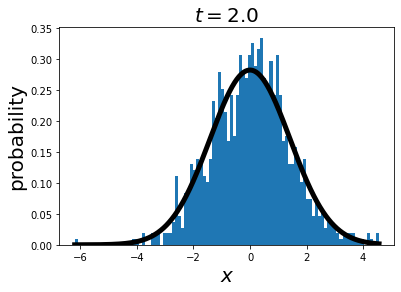

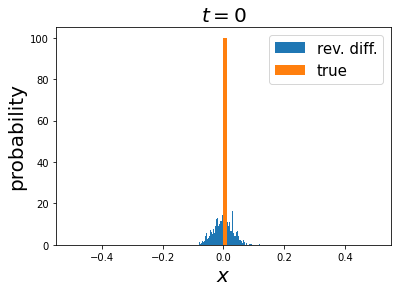

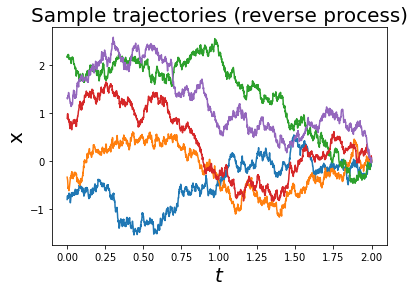

In [ ]:
# Compute exact transition probability
x_f_min, x_f_max = np.amin(x_traj[-1]), np.amax(x_traj[-1])
num_xf = 1000
x_f_arg = np.linspace(x_f_min, x_f_max, num_xf)
pdf_final = transition_probability_diffusion_exact(x_f_arg, T, params)


# Plot final distribution (distribution after diffusion / before reverse diffusion)
plt.hist(x_traj[-1], bins=100, density=True)
plt.plot(x_f_arg, pdf_final, color='black', linewidth=5)
plt.title("$t = $"+str(T), fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Plot initial distribution (distribution before diffusion / after reverse diffusion)
#fig, ax = plt.subplots(1, 2, width=)
plt.hist(x_traj_rev[-1], density=True, bins=100, label='rev. diff.')
plt.hist(x_traj[0], density=True, bins=100, label='true')

plt.title("$t = 0$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.legend(fontsize=15)
plt.show()


# Plot some trajectories
sample_trajectories = [0, 1, 2, 3, 4]
for s in sample_trajectories:
  plt.plot(t, x_traj_rev[:,s])
plt.title("Sample trajectories (reverse process)", fontsize=20)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("x", fontsize=20)
plt.show()

###Exercises

####**2.1: Why does the reverse stochastic process work?**

Consider a 1D Ito-interpreted SDE
$$\dot{x} = f(x, t) + g(t) \ \eta(t) \ ,$$
whose time-reversed process should be
$$\dot{x} = - f(x, T - t) + g(T - t)^2 \frac{\partial}{\partial x} \log p(x, T - t) + g(T - t) \ \eta(t) \ .$$
If indeed the latter process is the time-reverse of the former process, we expect that
$$q(x, t) = p(x, T - t) \ .$$
Note that the forward process satisfies the Fokker-Planck equation
$$\frac{\partial p(x, t)}{\partial t} = - \frac{\partial}{\partial x} \left[ \  f(x, t) p(x, t) \ \right] + \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, t)^2}{2} p(x, t) \ \right] \ .$$
By reversing time, we find that $p(x, T - t)$ satisfies
$$\frac{\partial p(x, T - t)}{\partial t} = \frac{\partial}{\partial x} \left[ \  f(x, T-t) p(x, T-t) \ \right] - \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, T-t)^2}{2} p(x, T-t) \ \right] \ .$$
Use this fact to show that $q(x, t) = p(x, T - t)$ is a solution to the Fokker-Planck equation
$$\frac{\partial q(x, t)}{\partial t} = - \frac{\partial}{\partial x} \left[ \  \left( f(x, T-t) - g(T-t)^2 \frac{\partial}{\partial x} \log p(x, T-t) \right)  q(x, t) \ \right] + \frac{\partial^2}{\partial x^2} \left[ \ \frac{g(x, T-t)^2}{2} q(x, t) \ \right] \ ,$$
and hence that we *did* write down an SDE that describes the reverse process after all.

####**2.2: Why does the reverse stochastic process work? Pt. 2**

Consider an $N$-dimensional Ito-interpreted SDE
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, t) + g(t) \ \boldsymbol{\eta}(t) \ ,$$
whose time-reversed process should be
$$\dot{\mathbf{x}} = - \mathbf{f}(\mathbf{x}, T - t) + g(T - t)^2 \ \nabla_{\mathbf{x}} \log p(\mathbf{x}, T - t) + g(T - t) \ \boldsymbol{\eta}(t) \ .$$
We expect that
$$q(\mathbf{x}, t) = p(\mathbf{x}, T - t) \ .$$
By generalizing the argument from the previous problem, show that $q(\mathbf{x}, t) = p(\mathbf{x}, T - t)$ satisfies the correct Fokker-Planck equation, and hence that we *did* write down an SDE that describes the reverse process.


####**2.3: Reverse processes in the case of state-dependent noise.**

Consider a 1D Ito-interpreted SDE
$$\dot{x} = f(x, t) + g(x, t) \ \eta(t) \ .$$
This differs from the one we considered above because the function $g$ is *state-dependent*; in other words, some states are noisier than others.

The argument we use to verify the reverse process (Exercise 2.1) doesn't work for this SDE. In fact, in this case the reverse process is **not** given by
$$\dot{x} = - f(x, T - t) + g(x, T - t)^2 \frac{\partial}{\partial x} \log p(x, T - t) + g(x, T - t) \ \eta(t) \ .$$
Why? Which part of our argument fails?

Can you come up with a more general expression for the reverse process which permits SDEs like this?

-------------------------------------------------------------------------

## 3. Learning the score function

Let's now try and actually solve the chicken and egg problem. We would like to sample from some target distribution—whose functional form is unknown, and which we can only access via samples—via reverse diffusion, but doing so requires that we know the score function corresponding to the target distribution. Knowing the score function, the gradient of the log of this distribution, appears to be equivalent to knowing the distribution itself. **How do we learn the score function?**

###Defining an objective function for score learning

First, let's write down a reasonable objective function. Suppose we have some parameterized approximation of the score function $\mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t)$ which depends upon a set of parameters $\boldsymbol{\theta}$. We want to accurately approximate the score function for all values of $\mathbf{x}$ and all values of $t$, so we might try to write down something like
$$J(\boldsymbol{\theta}) \stackrel{?}{:=} \frac{1}{2} \int d\mathbf{x} dt \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t)  \right]^2 \ .$$

This objective has the problem that it does not prioritize any particular value of $\mathbf{x}$ over the others. We are particularly interested in getting the score function right for values which are highly probable, so a reasonable modification of the above is
$$J(\boldsymbol{\theta}) \stackrel{?}{:=} \frac{1}{2} \int d\mathbf{x} dt \ p(\mathbf{x}, t) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t)  \right]^2 \ .$$

Similarly, we might consider adding a weighting factor which is different for different *times*, for the reason that the scale of deviations from the exact score function may change over time:
$$J_{naive}(\boldsymbol{\theta}) := \frac{1}{2} \int d\mathbf{x} dt \ \lambda(t) \  p(\mathbf{x}, t) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t)  \right]^2 \ .$$

This is a perfectly reasonable objective function. But we have a significant problem: namely, it is hard to estimate the gradient of the log of $p(\mathbf{x}, t)$, since $p(\mathbf{x}, t)$ may depend strongly on $p(\mathbf{x}, 0)$ (i.e. our target distribution). *And we don't know our target distribution, which is the reason we're doing all of this!*

At this point, we can use an interesting trick. Even though the above objective function is pretty reasonable, it's too hard to work with; the trick is to find an alternative objective function *with the same global minimum*. This turns out to be provided by
$$J_{mod}(\boldsymbol{\theta}) := \frac{1}{2} \int d\mathbf{x} d\mathbf{x}^{(0)} dt \ p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) p(\mathbf{x}^{(0)}) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)  \right]^2 \ .$$

Note that
$$
\begin{split}
\nabla_{\boldsymbol{\theta}} J_{naive}(\boldsymbol{\theta}) &= \int d\mathbf{x} dt \ p(\mathbf{x}, t) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t)  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t)  \\
&=  \int d\mathbf{x} dt \ p(\mathbf{x}, t) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \frac{\nabla_{\mathbf{x}} p(\mathbf{x}, t)}{p(\mathbf{x}, t)}  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) \\
&=  \int d\mathbf{x} dt \ \left[ \ p(\mathbf{x}, t) \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} p(\mathbf{x}, t) \  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) \\
&=  \int d\mathbf{x} d\mathbf{x}^{(0)} dt \ p(\mathbf{x}^{(0)}) \ \left[ \ p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) \  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) \\
&=  \int d\mathbf{x} d\mathbf{x}^{(0)} dt \ p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) p(\mathbf{x}^{(0)}) \ \left[ \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) \  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) \\
\end{split}
$$

$$
\begin{split}
\nabla_{\boldsymbol{\theta}} J_{mod}(\boldsymbol{\theta}) = \int d\mathbf{x} d\mathbf{x}^{(0)} dt \ p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) p(\mathbf{x}^{(0)}) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)  \right] \cdot \nabla_{\boldsymbol{\theta}} \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) \ .
\end{split}
$$

Actually, we've shown something stronger: these two objective functions are *identical*, as functions of $\boldsymbol{\theta}$, up to an additive constant.

Now that our objective function involves estimating the gradient of the log of the transition probability, which we can often compute *analytically* using knowledge of our forward stochastic process, it is usable.

The objective function we will go with is the last one (we'll remove the 'mod' subscript to endow it with extra importance):
$$
\begin{split}
J(\boldsymbol{\theta}) &:= \frac{1}{2} \int d\mathbf{x} d\mathbf{x}^{(0)} dt \ p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) p(\mathbf{x}^{(0)}) \ \left[ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)  \right]^2 \\
&= \frac{1}{2} \mathbb{E}_t\left\{  \ \lambda(t) \ \mathbb{E}_{\mathbf{x}^{(0)}} \mathbb{E}_{\mathbf{x} | \mathbf{x}^{(0)}} \left[ \ \Vert \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) \  \Vert^2_2 \ \right] \ \right\} \ .
\end{split}
$$
(Just to be extra clear, the expectation over time is taken with respect to a uniform distribution on $[0, T]$.)



###Approximating the objective function using samples

One nice benefit of writing the objective/loss function in terms of expectations is that this suggests a clear strategy for approximating it using samples: we can take a Monte-Carlo-type approach.

Given a sample $\mathbf{x}^{(0)}$ from our target distribution, we can do the following:

1.   Sample a time $t$ uniformly from $[0, T]$.
2.   Use our knowledge of the transition probability to sample $\mathbf{x} \sim p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)$.
3.   Use our knowledge of the transition probability to evaluate $\nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)$ for our samples.

Then we have an approximation
$$J(\boldsymbol{\theta}) \approx \frac{1}{2} \lambda(t) \left[ \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}, t) - \nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)  \ \right]^2 \ .$$

More generally, if we have a batch of $S$ samples, we can follow this procedure with each one and construct the approximation
$$J(\boldsymbol{\theta}) \approx \frac{1}{2 S} \sum_{j = 1}^S \lambda(t_j) \left[ \ \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}_j, t_j) - \nabla_{\mathbf{x}} \log p(\mathbf{x}_j, t | \mathbf{x}^{(0)}_j, 0)  \ \right]^2 \ .$$

Fortunately, the log of the transition probability tends to have a particularly simple form for the analytically tractable forward processes we'll be using. For example, for the VE SDE (see Section 2), which is defined via
$$\dot{\mathbf{x}} = \sqrt{ \frac{d[ \sigma^2(t) ]}{dt} } \ \boldsymbol{\eta}(t) \ ,$$
the corresponding transition probability is
$$
\begin{split}
p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) &= \frac{1}{\left[ \sqrt{2 \pi \sigma^2(t)} \right]^N} \exp\left\{ - \frac{\left[ \mathbf{x} - \mathbf{x}^{(0)} \right]^2}{2 \sigma^2(t)}  \right\} \ ,
\end{split}
$$
so the gradient of the log of the transition probability is
$$\nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0) = - \frac{\left[ \mathbf{x} - \mathbf{x}^{(0)} \right]}{\sigma^2(t)} \ .$$

Now that we can approximately evaluate the loss function, we can let the computer take care of gradients...and the rest is compute time**!

** and lots and lots of implementation details




###Function approximation via deep neural networks

Now that we have a well-defined optimization problem, and a straightforward algorithm for solving it, we can throw all sorts of tools at the problem to make solving it more manageable. Since we need to construct some parameterized approximation of the score function, *(deep) neural networks* are one such tool.

This jump to neural networks does not require any substantial conceptual changes to the picture we have outlined above. As you will see in the second (coding-focused) notebook of this session, once everything else is set up, incorporating neural networks as score function approximators is actually pretty trivial. The *benefits*, of course, are another story.

###Exercises

####**3.1: More explicit objective functions.**

The objective function we defined above involves evaluating $\nabla_{\mathbf{x}} \log p(\mathbf{x}, t | \mathbf{x}^{(0)}, 0)$ at samples $\mathbf{x}$ and $\mathbf{x}^{(0)}$. This is easiest when we have closed-form expressions for the transition probability.

Write down the full objective function, with this term evaluated explicitly, for the three SDEs described at the end of Section 2: the (i) VE SDE, (ii) VP SDE, and (iii) sub-VP SDE.

----------------------------------

##End

Nice job getting through this notebook! Good luck with Day 2!